## PS4 games rating predictions
*Comparing 8 regression algorithms *
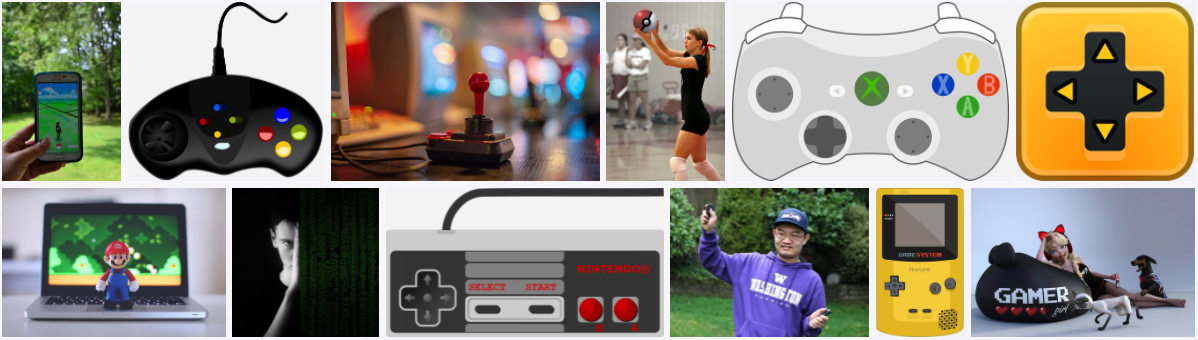
**Table of contents**

1. Data Description

2. Data Preprocessing

3. Model comparison

4. Prediction metrics of the best model using the test set

5. Visualization of the result



**Context**
This dataset include all games for PlayStation 4 for the present. I used the truetrophies website to create this dataset.

**Content**
You can find 1 datasets : games_data.csv: contend up to date list of PlayStation 4 (PS4) games , games name and some details like score, rating for each game etc.

This dataset includes 1584 games information


# Load the libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from time import perf_counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

import warnings
warnings.filterwarnings(action='ignore')

#1.Data Description

In [3]:
df= pd.read_csv("/content/games_data.csv")

In [4]:
df.head()

,Unnamed: 0,game,score,leaderbord,gamers,comp_perc,rating,url,min_comp_time,max_comp_time
0,0,A Boy and His Blob,638,2.02,2194,16.5,3.2,https://www.truetrophies.com/game/A-Boy-and-Hi...,15,20
1,1,A Hat in Time,1992,1.53,7062,35.9,4.2,https://www.truetrophies.com/game/A-Hat-in-Tim...,15,20
2,2,A Hero and a Garden,1364,1.01,503,97.6,5.0,https://www.truetrophies.com/game/A-Hero-and-a...,0,1
3,3,A Hero and a Garden (EU),1363,1.01,581,97.8,2.9,https://www.truetrophies.com/game/A-Hero-and-a...,0,1
4,4,A King's Tale: Final Fantasy XV,637,2.02,21914,14.1,3.3,https://www.truetrophies.com/game/A-Kings-Tale...,4,5


In [6]:
df.describe()

,Unnamed: 0,score,leaderbord,gamers,comp_perc,rating,min_comp_time,max_comp_time
count,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000
mean,791.500000,1894.984217,1.583971,18589.357323,49.020455,3.095455,16.231061,25.275884
std,457.405728,1389.680978,0.748916,33676.397335,35.220544,0.973732,28.020810,70.424345
min,0.000000,189.000000,1.000000,60.000000,0.000000,0.500000,0.000000,1.000000
25%,395.750000,1313.000000,1.050000,1141.000000,14.200000,2.400000,0.000000,1.000000
50%,791.500000,1458.500000,1.300000,3909.500000,45.600000,3.300000,5.000000,6.000000
75%,1187.250000,2419.250000,1.880000,18920.500000,86.525000,3.900000,20.000000,25.000000
max,1583.000000,12017.000000,7.380000,245220.000000,99.600000,5.000000,200.000000,700.000000


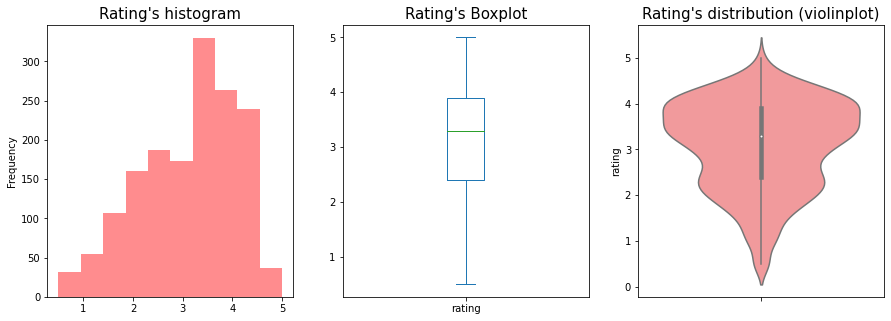

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

df['rating'].plot.hist(by='rating',ax = axes[0], color = '#ff8c8e')
axes[0].set_title('Rating\'s histogram', fontsize = 15)

df['rating'].plot.box(ax = axes[1])
axes[1].set_title('Rating\'s Boxplot', fontsize = 15)

sns.violinplot(ax = axes[2], y = 'rating', data = df, color = '#ff8c8e')
axes[2].set_title('Rating\'s distribution (violinplot)', fontsize = 15)

plt.show()

In [9]:
printmd(f'### Number of rows in the dataset: {df.shape[0]}')

### Number of rows in the dataset: 1584

#2. Data Preprocessing

In [10]:
def preprocessing(df):
    df = df.copy()
    
    # Drop game and URL columns
    df = df.drop('game', axis=1)
    df = df.drop('url', axis=1)
    
    # Shuffle the data
    df = df.sample(frac=1.0, random_state=0).reset_index(drop=True)
    
    X = df.drop('rating', axis=1)
    y = df['rating']
    
    X = pd.DataFrame(X, index=X.index, columns=X.columns)
    
    return X, y

# Preprocessing
X,y = preprocessing(df)

# Split into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the datasets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Display the result
X_train[:2], y_train[:2]

(array([[ 0.89003277,  1.11472153, -0.57978858, -0.06848948, -0.14096558,
         -0.57708129, -0.35559967],
        [ 0.66608134, -0.3842809 , -0.76846691, -0.49978865,  1.39889024,
         -0.57708129, -0.35559967]]), 142    3.1
 736    1.6
 Name: rating, dtype: float64)

#3. Model Comparison

In [11]:
models = {
    "LinearRegression":{"model":LinearRegression() },
    "Lasso":{"model":Lasso() },
    "Ridge":{"model":Ridge() },
    "DecisionTreeRegressor":{"model":DecisionTreeRegressor() },
    "RandomForestRegressor":{"model":RandomForestRegressor() },
    "MLPRegressor":{"model":MLPRegressor() },
    "GradientBoostingRegressor":{"model":GradientBoostingRegressor() },
    "AdaBoostRegressor":{"model":AdaBoostRegressor() }
}

# Use the K-fold cross validation for each model
# to get the mean validation accuracy and the mean training time
k = 10
for name, m in models.items():
    # Cross validation of the model
    model = m['model']
    result = cross_validate(model, X_train,y_train, cv = k, scoring='neg_mean_squared_error')
    
    # Mean accuracy and mean training time
    result['test_score'] = result['test_score']
    mean_RMSE = [(-x)**0.5 for x in result['test_score']] # Root Mean Square Error
    mean_RMSE = sum(mean_RMSE)/len(mean_RMSE)
    mean_RMSE = round(mean_RMSE,4)
    mean_fit_time = round( sum(result['fit_time']) / len(result['fit_time']), 4)
    
    # Add the result to the dictionary witht he models
    m['mean_RMSE'] = mean_RMSE
    m['Training time (sec)'] = mean_fit_time
    
    # Display the result
    print(f"{name:27} mean MSRE for {k}-fold CV: {mean_RMSE} - mean training time {mean_fit_time} sec")

LinearRegression            mean MSRE for 10-fold CV: 0.6743 - mean training time 0.0027 sec
Lasso                       mean MSRE for 10-fold CV: 0.9742 - mean training time 0.0013 sec
Ridge                       mean MSRE for 10-fold CV: 0.6742 - mean training time 0.0016 sec
DecisionTreeRegressor       mean MSRE for 10-fold CV: 0.8153 - mean training time 0.0073 sec
RandomForestRegressor       mean MSRE for 10-fold CV: 0.5874 - mean training time 0.5981 sec
MLPRegressor                mean MSRE for 10-fold CV: 0.6285 - mean training time 1.3933 sec
GradientBoostingRegressor   mean MSRE for 10-fold CV: 0.6054 - mean training time 0.2097 sec
AdaBoostRegressor           mean MSRE for 10-fold CV: 0.6467 - mean training time 0.1408 sec


In [12]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    lst = [name, v['mean_RMSE'],v['Training time (sec)']]
    models_result.append(lst)

df_results = pd.DataFrame(models_result, 
                          columns = ['model','RMSE','Training time (sec)'])
df_results.sort_values(by='RMSE', ascending=True, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,RMSE,Training time (sec)
0,RandomForestRegressor,0.5874,0.5981
1,GradientBoostingRegressor,0.6054,0.2097
2,MLPRegressor,0.6285,1.3933
3,AdaBoostRegressor,0.6467,0.1408
4,Ridge,0.6742,0.0016
5,LinearRegression,0.6743,0.0027
6,DecisionTreeRegressor,0.8153,0.0073
7,Lasso,0.9742,0.0013


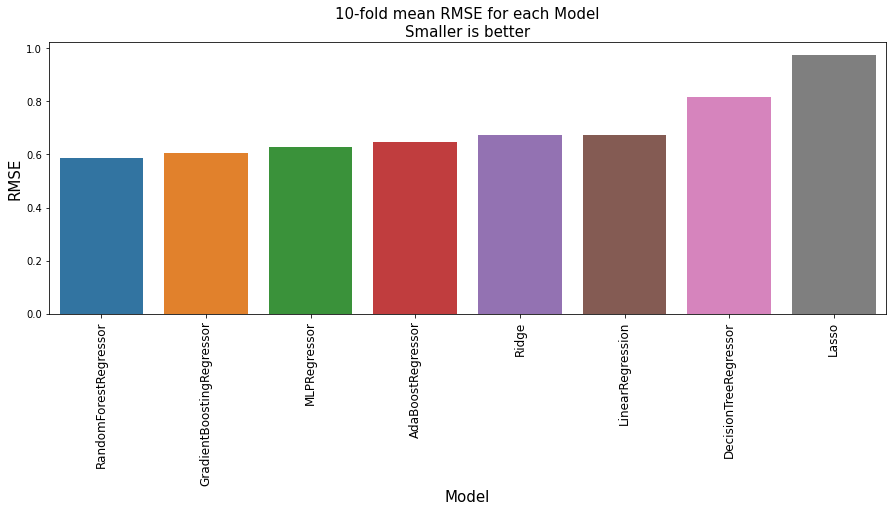

In [13]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'RMSE', data = df_results)
plt.title(f'{k}-fold mean RMSE for each Model\nSmaller is better', fontsize = 15)
# plt.ylim(0.8,1.005)
plt.xlabel('Model', fontsize=15)
plt.ylabel('RMSE',fontsize=15)
plt.xticks(rotation=90, fontsize=12)
plt.show()

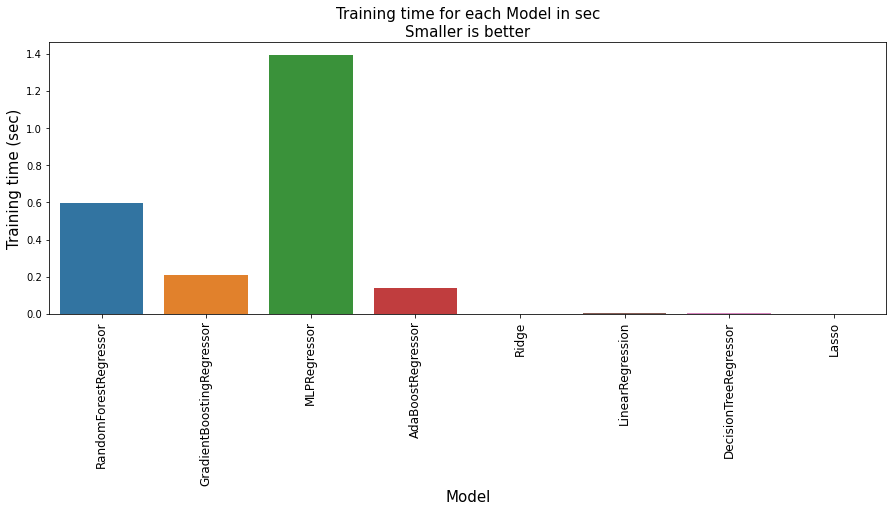

In [14]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each Model in sec\nSmaller is better', fontsize = 15)
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Training time (sec)',fontsize=15)
plt.show()

# 4. Prediction metrics of the best model using the test set

In [15]:
# Get the model with the highest mean validation accuracy
best_model = df_results.iloc[0]

# Fit the model
model = models[best_model[0]]['model']
model.fit(X_train,y_train)

# Predict the labels with the data set
pred = model.predict(X_test)

MSRE = mean_squared_error(y_test,pred)**0.5
MSRE = round(MSRE, 2)

# Display the results
printmd(f'### Best Model: {best_model[0]} with a MSRE of {MSRE} on the test set')
printmd(f'### Trained in: {best_model[2]} sec')

### Best Model: RandomForestRegressor with a MSRE of 0.58 on the test set

### Trained in: 0.5981 sec

# 5. Visualization of the result

In [16]:
# Concatenate the ratings of the test set
# with the predictions of those ratings
pred_s = pd.Series(pred)
y_test_s = y_test.reset_index(drop=True)

df_result = pd.concat([y_test_s,pred_s], axis = 1)
df_result.columns = ['Real Rating', 'Predicted Rating']
df_result.head(5)

,Real Rating,Predicted Rating
0,2.3,2.289
1,2.9,3.664
2,1.7,1.833
3,3.5,4.163
4,3.8,3.961


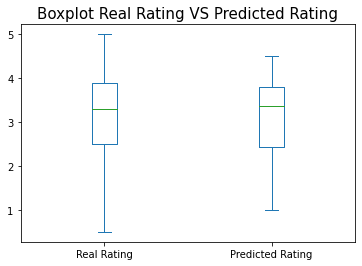

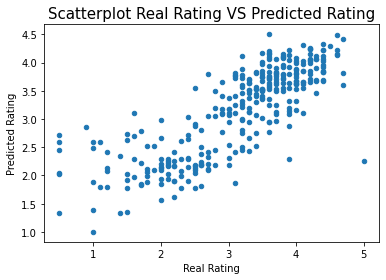

In [17]:
df_result.plot.box()
plt.title('Boxplot Real Rating VS Predicted Rating', fontsize = 15)
plt.show()

df_result.plot.scatter(x='Real Rating', y='Predicted Rating')
plt.title('Scatterplot Real Rating VS Predicted Rating', fontsize = 15)
plt.show()